# Sarcasm Detection using TF-Keras
Trying and understanding the code written by Saai Sudarsanan D (https://www.kaggle.com/saaisudarsanand/sarcasm-detection-using-tf-keras). He achieved 92% accuracy rate for detecting sarcasm from the following datasets: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
%matplotlib inline
import json
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling1D,Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential,Model,Input

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


In [40]:
dir1 = "../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json"
dir2 = "../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"

In [41]:
sens = []
labels = []
for line in open(dir1, 'r'):
    temp = []
    temp.append(json.loads(line))
    sens.append(temp[0]["headline"])
    labels.append(temp[0]["is_sarcastic"])
for line in open(dir2, 'r'):
    temp = []
    temp.append(json.loads(line))
    sens.append(temp[0]["headline"])
    labels.append(temp[0]["is_sarcastic"])
print("sens Length:",len(sens),"\nlabels Length:",len(labels))

sens Length: 55328 
labels Length: 55328


In [42]:
df = pd.DataFrame(columns = ["sens","labels"])
df["sens"] = np.array(sens)
df["labels"] = np.array(labels)

eda_tokenizer = Tokenizer(oov_token = "<OOV>")
word_index = eda_tokenizer.word_index

eda_tokenizer.fit_on_texts(sens)
sequences = eda_tokenizer.texts_to_sequences(sens)
pad_all = pad_sequences(sequences,padding = "post")

In [43]:
sp = np.array(pad_all)
df.head()

,sens,labels
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [44]:
df.isnull().sum()

sens      0
labels    0
dtype: int64

### EDA - Explanatory Data Analysis

<AxesSubplot:xlabel='labels', ylabel='count'>

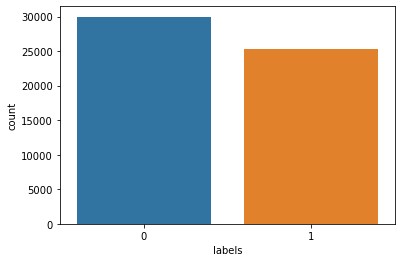

In [45]:
sns.countplot(x = "labels",data = df)

Consideration of word cloud above: Should be considered that word clouds display emphasis frequency of words, not necessarily their importance

### Vocab
**Tokenizer** -  It converts input text to streams of tokens, where each token is a separate word, punctuation sign, number/amount, date, e-mail, URL/URI, etc.

In [46]:
ones = df.where(df["labels"] == 1).dropna().reset_index().drop(["index"],axis = 1)
zeros = df.where(df["labels"] == 0).dropna().reset_index().drop(["index"],axis = 1)
sens_train = []
sens_test = []
labels_train = []
labels_test = []
for data in [ones,zeros]:
    sens_train += list(data["sens"])[0:20000]
    sens_test += list(data["sens"])[20000:]
    labels_train += list(data["labels"])[0:20000]
    labels_test += list(data["labels"])[20000:]

print("Train Sentences Length:",len(sens_train),"\nTest Sentences Length:",len(sens_test))
print("Train Labels Length:",len(labels_train),"\nTest Labels Length:",len(labels_test))
                      
tokenizer = Tokenizer(oov_token = "<OOV>")
word_index = tokenizer.word_index

tokenizer.fit_on_texts(sens_train)
seq_train = tokenizer.texts_to_sequences(sens_train)
pad_train = pad_sequences(seq_train,padding = "post")

Train Sentences Length: 40000 
Test Sentences Length: 15328
Train Labels Length: 40000 
Test Labels Length: 15328


In [47]:
def plot_wordcloud(df):
    words = '' 
    stopwords = set(STOPWORDS) 

    # iterate through the csv file 
    for val in df.values: 

        # typecaste each val to string 
        val = str(val) 

        # split the value 
        tokens = val.split() 

        # Converts each token into lowercase 
        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (20,16), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

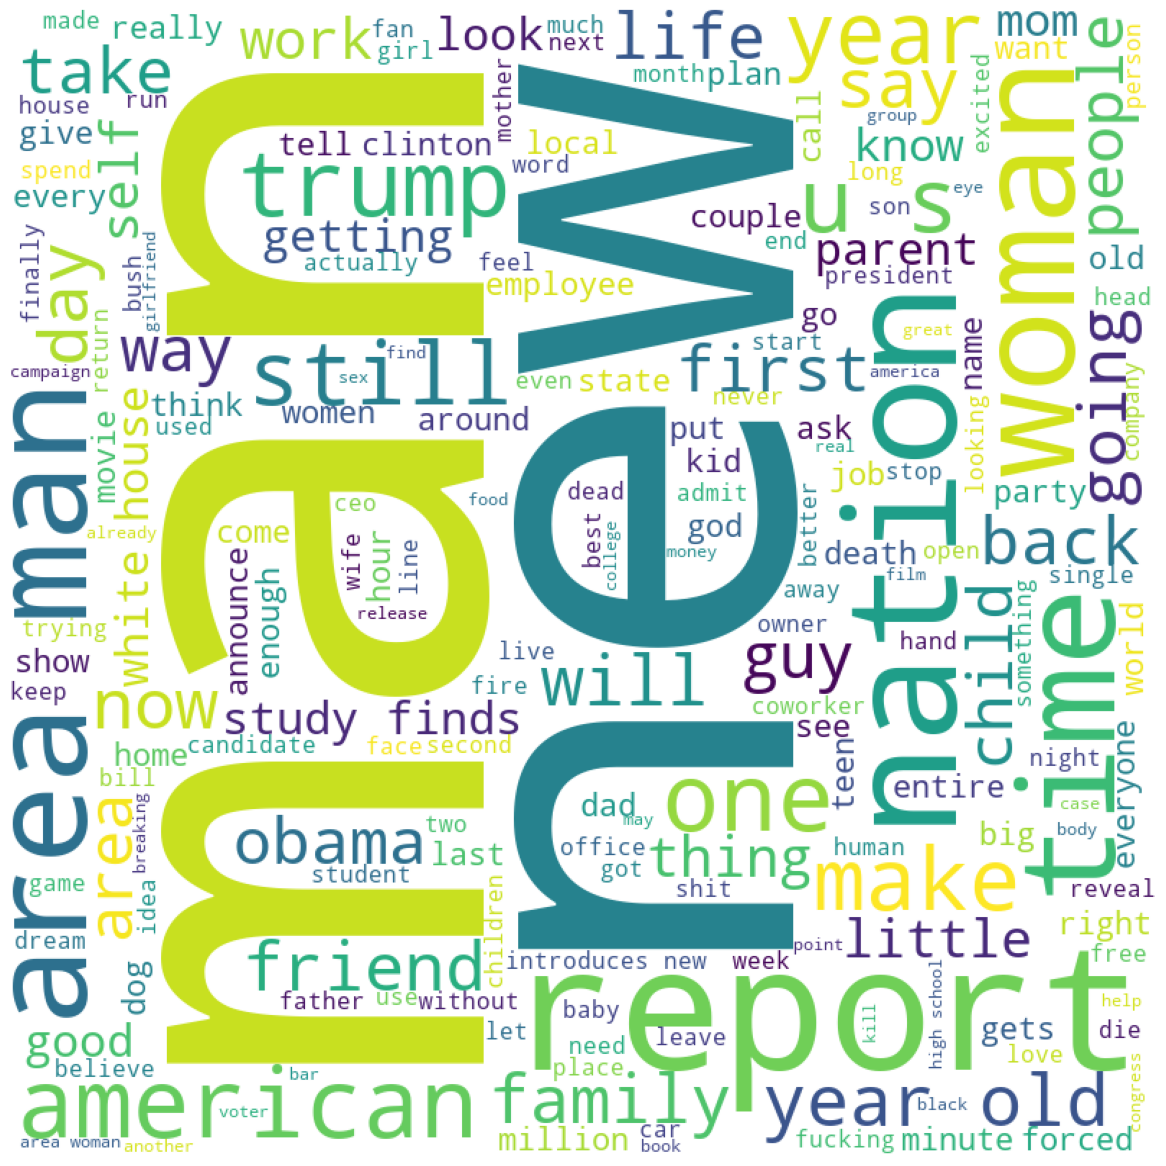

In [48]:
plot_wordcloud(ones["sens"])

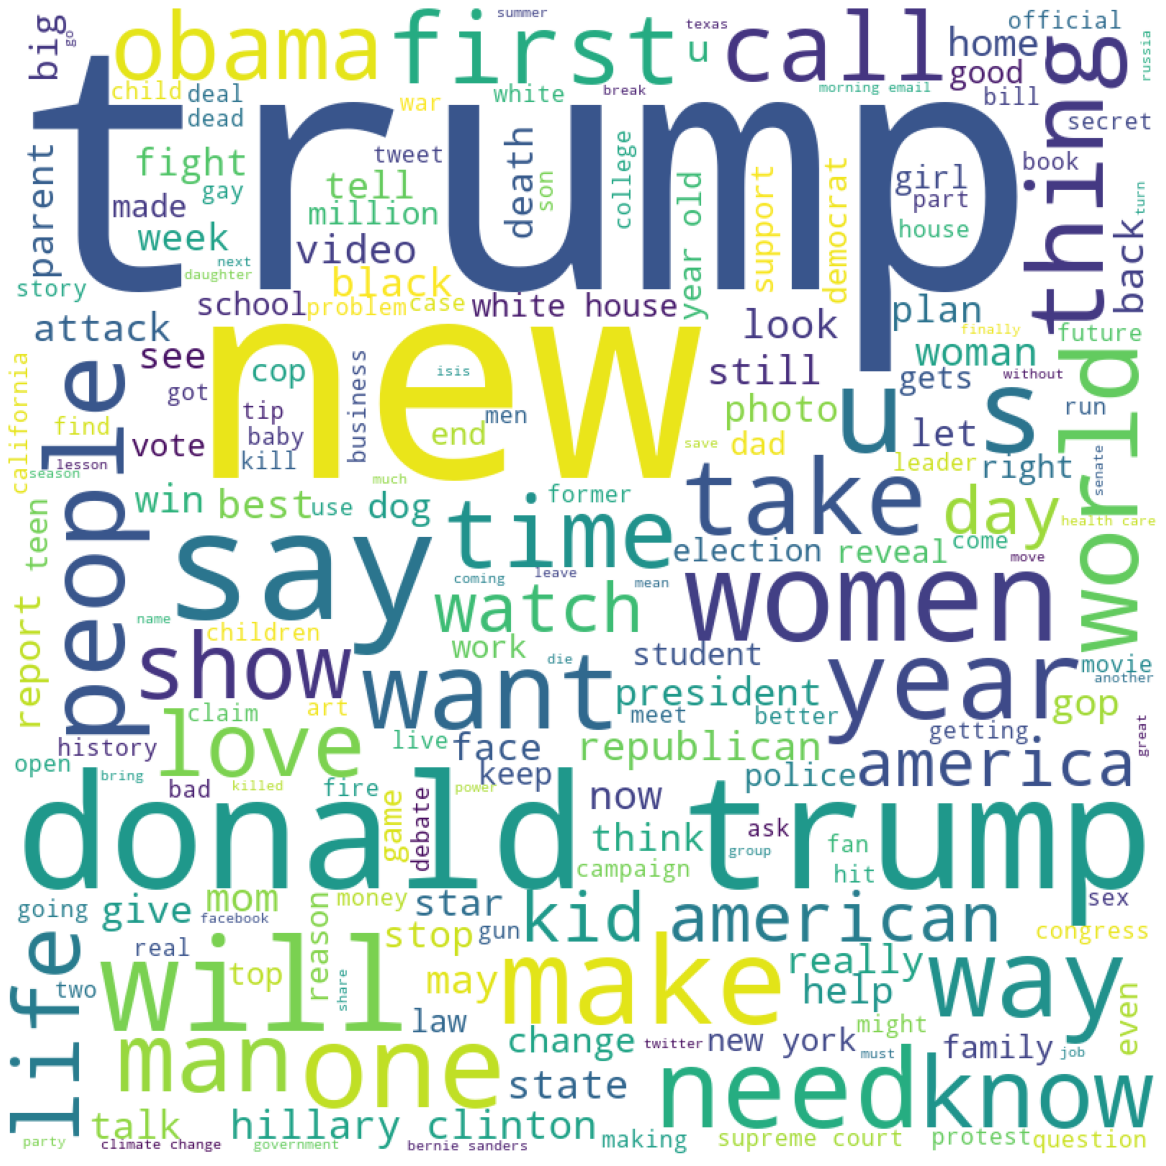

In [49]:
plot_wordcloud(zeros["sens"])

### Model

In [50]:
training_padded = np.array(pad_train)
training_labels = np.array(labels_train)

In [51]:
input_layer = Input(shape = (152,))
emb = Embedding(46708,125,input_length = 152)(input_layer)
gal = GlobalAveragePooling1D()(emb)
d1 = Dense(24,activation = "relu")(gal)
drop1 = tf.keras.layers.Dropout(0.2)(d1)
d2 = Dense(12,activation = "relu")(drop1)
drop2 = tf.keras.layers.Dropout(0.2)(d2)
d3 = Dense(1,activation = "sigmoid")(drop2)
model = Model(inputs = input_layer,outputs = d3)
model.compile(loss = "binary_crossentropy",optimizer = tf.keras.optimizers.Adam(lr = 0.001),metrics = ["accuracy"])
history = model.fit(training_padded,training_labels,validation_split = 0.2,shuffle = True,epochs = 10)

Epoch 1/10
1000/1000 [==============================] - 44s 43ms/step - loss: 0.6173 - accuracy: 0.6603 - val_loss: 0.3919 - val_accuracy: 0.9162
Epoch 2/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.3077 - accuracy: 0.8864 - val_loss: 0.3528 - val_accuracy: 0.8875
Epoch 3/10
1000/1000 [==============================] - 43s 43ms/step - loss: 0.1996 - accuracy: 0.9342 - val_loss: 0.3038 - val_accuracy: 0.9124
Epoch 4/10
1000/1000 [==============================] - 40s 40ms/step - loss: 0.1433 - accuracy: 0.9595 - val_loss: 0.3085 - val_accuracy: 0.9146
Epoch 5/10
1000/1000 [==============================] - 40s 40ms/step - loss: 0.1001 - accuracy: 0.9741 - val_loss: 0.5656 - val_accuracy: 0.8445
Epoch 6/10
1000/1000 [==============================] - 45s 45ms/step - loss: 0.0826 - accuracy: 0.9784 - val_loss: 0.2619 - val_accuracy: 0.9396
Epoch 7/10
1000/1000 [==============================] - 49s 49ms/step - loss: 0.0690 - accuracy: 0.9818 - val_loss: 0.3474 -

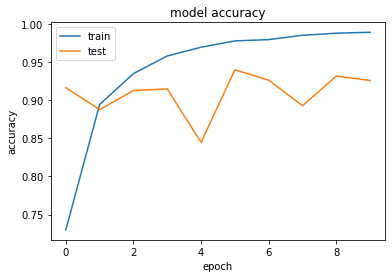

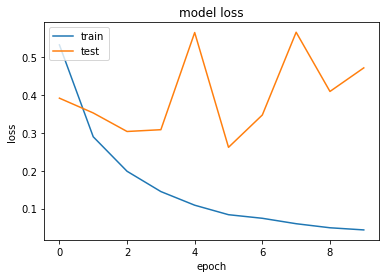

In [55]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluation


In [56]:
seq_test = tokenizer.texts_to_sequences(sens_test)
pad_test = pad_sequences(seq_test,padding = "post")
test_padded = np.array(pad_test)
test_labels = np.array(labels_test)

In [57]:
model.evaluate(test_padded,test_labels)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1183 test_step
        y_pred = self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 152), found shape=(32, 39)


In [60]:
sentence = ["I am extremely grateful to you","I am grateful to you"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences)
print(model.predict(padded))

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1478 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1461 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1434 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer model_1: expected shape=(None, 152), found shape=(None, 6)


In [61]:
def get_results(sen):
    sequences = tokenizer.texts_to_sequences(sen)
    padded = pad_sequences(sequences)
    pred = model.predict(padded)
    if pred[0][0] < 0.7:
        print("\"" + sen + "\"" + " is not sarcastic " + str(100 - pred[0][0]*100) + "%")
    else:
        print("\"" + sen + "\"" + " is sarcastic " + str(pred[0][0]*100) + "%")

In [62]:
get_results("I am alright")

"I am alright" is not sarcastic 100.0%


In [63]:
get_results("We are happy")

"We are happy" is not sarcastic 100.0%


In [64]:
get_results("Are you alright?") 

"Are you alright?" is not sarcastic 100.0%


In [65]:
get_results("You are very very nice")

"You are very very nice" is sarcastic 100.0%


In [66]:
get_results("You look soooo beautiful")

"You look soooo beautiful" is sarcastic 100.0%


In [67]:
get_results("cats hate dogs")

"cats hate dogs" is not sarcastic 99.99999901042074%


In [68]:
get_results("You are perfect")

"You are perfect" is sarcastic 100.0%
